Time Series Forecasting with XGBoost

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

In [95]:
noaaData = pd.read_csv('../10-timeSeriesForecastingXGBoost/data/Auckland_NOAA.csv')
noaaData.tail()



,STATION,NAME,DATE,PRCP,TAVG,TMAX,TMIN
10516,NZM00093110,"AUCKLAND AERO AWS, NZ",2023-07-08,0.39,53,61.0,NaN
10517,NZM00093110,"AUCKLAND AERO AWS, NZ",2023-07-09,0.09,55,59.0,46.0
10518,NZM00093110,"AUCKLAND AERO AWS, NZ",2023-07-10,0.13,56,60.0,48.0
10519,NZM00093110,"AUCKLAND AERO AWS, NZ",2023-07-11,0.16,55,60.0,NaN
10520,NZM00093110,"AUCKLAND AERO AWS, NZ",2023-07-12,0.15,56,61.0,52.0


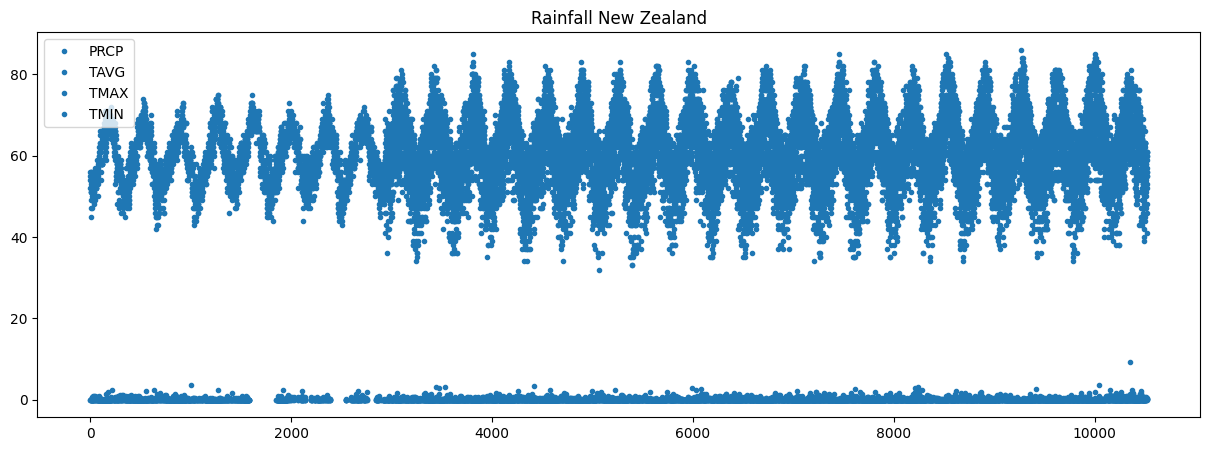

In [96]:
noaaData.plot(style='.', figsize=(15,5), color=color_pal[0], title='Rainfall New Zealand')
plt.show()

In [97]:
noaaData.index

RangeIndex(start=0, stop=10521, step=1)

In [98]:
noaaData.columns

Index(['STATION', 'NAME', 'DATE', 'PRCP', 'TAVG', 'TMAX', 'TMIN'], dtype='object')

<Axes: title={'center': 'Rainfall Auckland 1994 to 2023 (NOAA)'}, xlabel='Year', ylabel='Rainfall'>

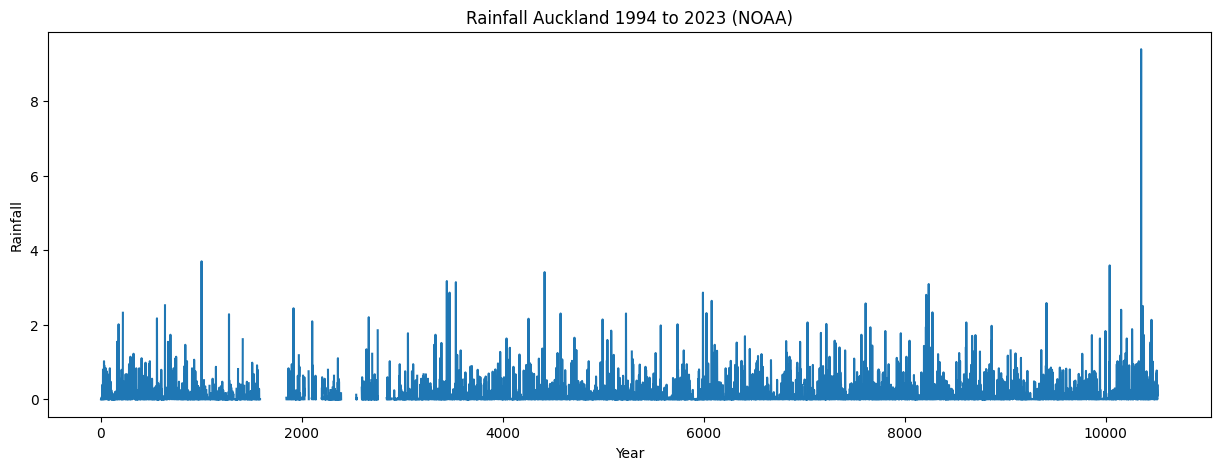

In [99]:
noaaData['PRCP'].plot(figsize=(15,5),  title='Rainfall Auckland 1994 to 2023 (NOAA)', xlabel="Year", ylabel='Rainfall')

<Axes: title={'center': 'Rainfall Auckland 1994 to 2023 (NOAA)'}, xlabel='Year', ylabel='Rainfall'>

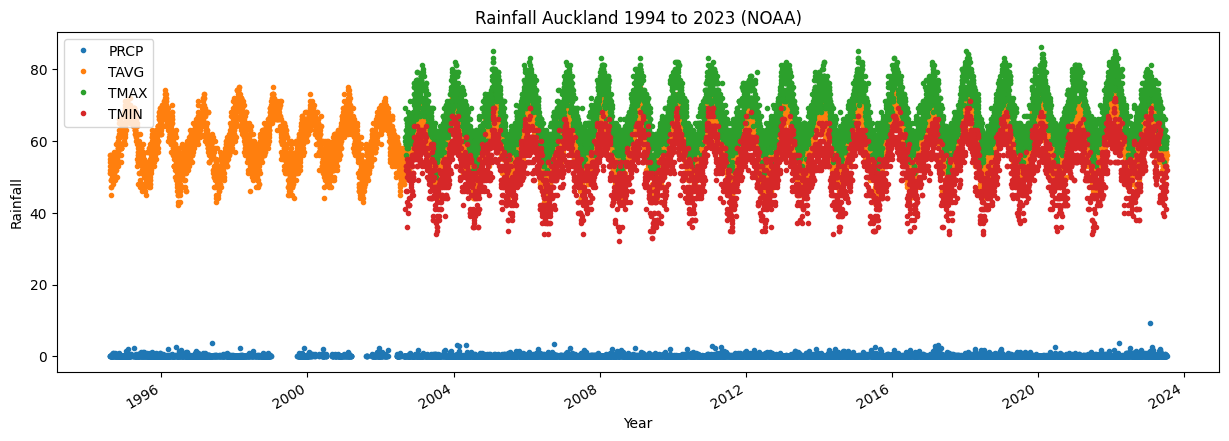

In [100]:
noaaData = noaaData.set_index('DATE')
noaaData.index = pd.to_datetime(noaaData.index)
noaaData.plot(style='.', figsize=(15,5), title='Rainfall Auckland 1994 to 2023 (NOAA)', xlabel="Year", ylabel='Rainfall')

Tras/ Test/ Split

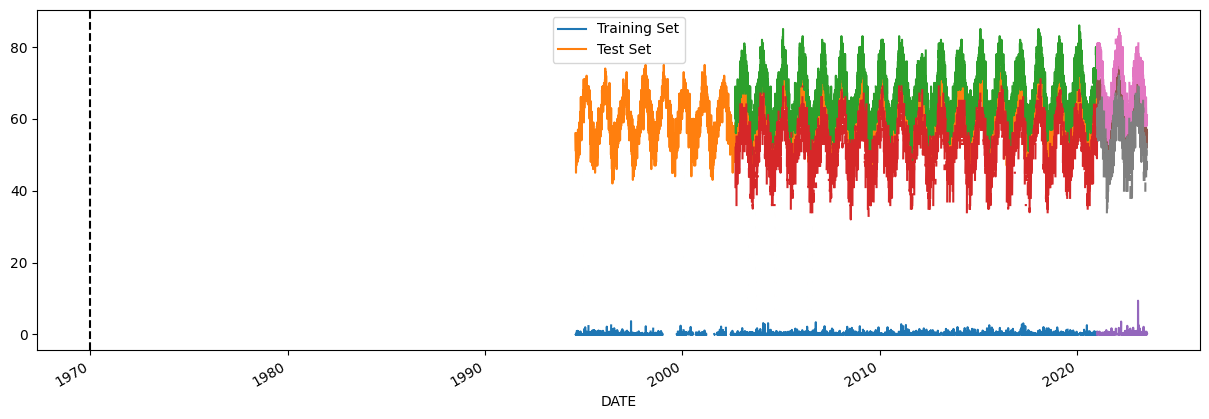

In [101]:
train = noaaData.loc[noaaData.index < '2020-12-31']
test = noaaData.loc[noaaData.index >= '2021-12-31']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set")
test.plot(ax=ax, label="Testing Set")
ax.axvline( color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

look for 1 week of data

<Axes: title={'center': 'Week of Data'}, xlabel='DATE'>

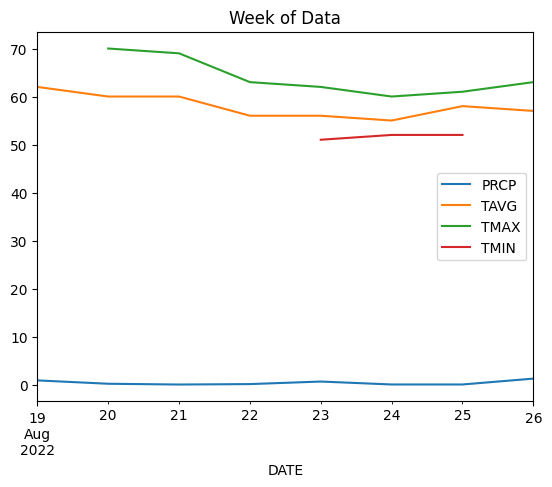

In [102]:
noaaData.loc[(noaaData.index > '2022-08-18') & (noaaData.index < '2022-08-27')].plot(title='Week of Data')

Feature Creation

In [103]:
noaaData.index.min


<bound method Index.min of DatetimeIndex(['1994-08-02', '1994-08-03', '1994-08-04', '1994-08-05',
               '1994-08-06', '1994-08-07', '1994-08-08', '1994-08-09',
               '1994-08-10', '1994-08-11',
               ...
               '2023-07-03', '2023-07-04', '2023-07-05', '2023-07-06',
               '2023-07-07', '2023-07-08', '2023-07-09', '2023-07-10',
               '2023-07-11', '2023-07-12'],
              dtype='datetime64[ns]', name='DATE', length=10521, freq=None)>

Create features

In [104]:
def create_features(df):
    '''
    Create time series features based on time series index
    '''
    df = df.copy()
    df['hour'] = noaaData.index.hour
    df['dayofweek'] = noaaData.index.dayofweek
    df['quarter'] = noaaData.index.quarter
    df['month'] = noaaData.index.month
    df['year'] = noaaData.index.year
    df['dayofyear'] = noaaData.index.dayofyear
    return df

df = create_features(noaaData)

Visualize our feature / Target Relationship

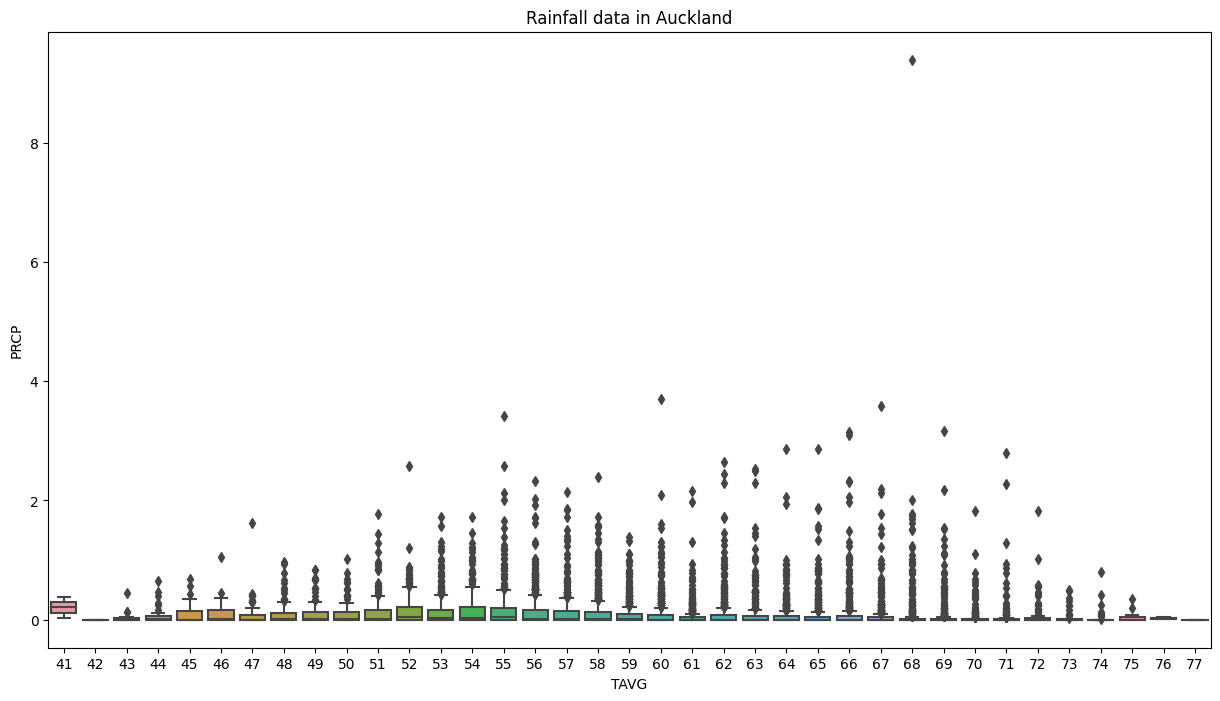

In [105]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=noaaData, x='TAVG', y='PRCP')
ax.set_title('Rainfall data in Auckland')
plt.show()

Create our model

In [106]:
train = create_features(train)
test = create_features(test)

ValueError: Length of values (10521) does not match length of index (9601)

In [ ]:
df.columns

Index(['STATION', 'NAME', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'hour', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear'],
      dtype='object')

In [ ]:
FEATURES = ['NAME', 'TAVG', 'TMAX', 'TMIN', 'hour', 'dayofweek',
       'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PRCP'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

KeyError: "['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'] not in index"

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],  verbose=True)